# 0. Install and Import Dependencies

In [3]:
!pip install opencv-python matplotlib imageio tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [5]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [10]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [15]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [17]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

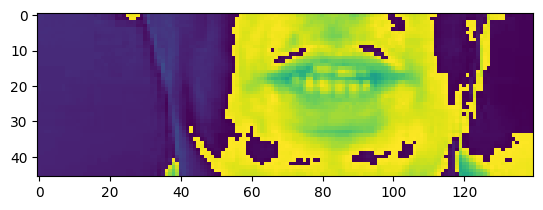

In [18]:
plt.imshow(frames[40])

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [24]:
len(test)

50

In [25]:
frames, alignments = data.as_numpy_iterator().next()

In [26]:
len(frames)

2

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[1.2559257 ],
          [1.2559257 ],
          [1.2559257 ],
          ...,
          [0.11081697],
          [0.        ],
          [0.        ]],

         [[1.2559257 ],
          [1.2559257 ],
          [1.2559257 ],
          ...,
          [0.07387798],
          [0.03693899],
          [0.03693899]],

         [[1.2189866 ],
          [1.2189866 ],
          [1.2189866 ],
          ...,
          [0.14775595],
          [0.03693899],
          [0.03693899]],

         ...,

         [[0.88653576],
          [0.88653576],
          [0.88653576],
          ...,
          [8.976174  ],
          [9.086991  ],
          [9.086991  ]],

         [[0.88653576],
          [0.88653576],
          [0.88653576],
          ...,
          [9.050053  ],
          [9.013113  ],
          [8.902296  ]],

         [[0.88653576],
          [0.88653576],
          [0.88653576],
          ...,
          [9.271687  ],
          [9.234747  ],
          [8.902296  ]]],


        [[[1.2189

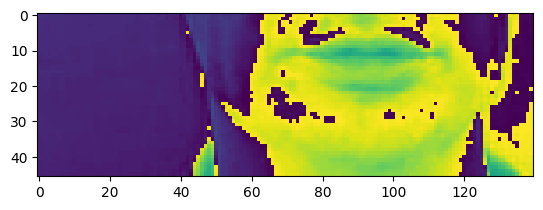

In [29]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in l three soon'>

# 3. Design the Deep Neural Network

In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, LSTM, Dense, Dropout, Bidirectional, MaxPool2D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [32]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [13]:
model = Sequential()

# Reduced filters for TimeDistributed Conv2D layers
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(75, 46, 140, 1)))
model.add(TimeDistributed(MaxPool2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2))))

# Flatten and reshape for LSTM layers
model.add(TimeDistributed(Flatten()))
model.add(Reshape((75, -1)))

# Reduced LSTM units
model.add(Bidirectional(LSTM(64, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Reduced Dense layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 75, 46, 140, 32)  320       
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 75, 23, 70, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 75, 23, 70, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 75, 11, 35, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 75, 11, 35, 128) 

In [35]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [36]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaannn'>

In [37]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaannn'>

In [38]:
model.input_shape   

(None, 75, 46, 140, 1)

In [39]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [40]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [41]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.original_dataset = dataset  # Keep a reference to the original dataset

    def on_epoch_begin(self, epoch, logs=None):
        # Recreate the iterator from the original dataset at the beginning of each epoch
        self.dataset = self.original_dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)


In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [44]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','2dcheckpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [45]:
schedule_callback = LearningRateScheduler(scheduler)

In [46]:
example_callback = ProduceExample(test)

In [60]:
# Please skip this cell if you are not training the model
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])
model.save('models/2dcheckpoint.weights.h5')

1/1 [==============================] - 0s 185ms/step loss: 45.33
Original: bin blue by f eight please
Prediction: in bue b ie plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with q zero please
Prediction: se re t or plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 431s 958ms/step - loss: 45.3316 - val_loss: 39.3329 - lr: 1.0000e-04
Epoch 20/80
1/1 [==============================] - 0s 211ms/step loss: 44.26
Original: place green by e four please
Prediction: plac re or plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green in l six please
Prediction: lay re n i plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 443s 986ms/step - loss: 44.2654

# 5. Make a Prediction 

In [ ]:
model.load_weights('models/2dcheckpoint.weights.h5')

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [61]:
test_data = test.as_numpy_iterator()

In [62]:
sample = test_data.next()

In [63]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 100ms/step


In [64]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by a six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue in a two please'>]

In [65]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [66]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by ix plase'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue i o plase'>]

# Test on a Video

In [67]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [68]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [69]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 65ms/step


In [70]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [71]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red a nie again'>]